In [4]:
import pandas as pd
import pandas as pd

df_cleaned = pd.read_csv("data/processed/labeled_time_series.csv")
df_cleaned["date"] = pd.to_datetime(df_cleaned["date"])
df_cleaned.head()

# 0) date format
df_cleaned["date"] = pd.to_datetime(df_cleaned["date"])

# 1) feature cols
META = {"Country", "date"}
feature_cols = [c for c in df_cleaned.columns if c not in META]

# 2) rolling cutoffs
max_date = df_cleaned["date"].max()
cutoff_3y = max_date - pd.DateOffset(years=3)
cutoff_2y = max_date - pd.DateOffset(years=2)
cutoff_6m = max_date - pd.DateOffset(months=6)

df_3y_raw = df_cleaned[df_cleaned["date"] >= cutoff_3y].copy()
df_2y_raw = df_cleaned[df_cleaned["date"] >= cutoff_2y].copy()
df_6m_raw = df_cleaned[df_cleaned["date"] >= cutoff_6m].copy()

# 3) coverage check (%60+ week coverage)
def check_coverage(df_raw, name, threshold=0.6):
    total_weeks = df_raw["date"].nunique()
    cov = df_raw.groupby("Country")["date"].nunique() / total_weeks
    valid = cov[cov >= threshold].index
    print(f"{name} - %{int(threshold*100)}+ coverage: {len(valid)}/{df_raw['Country'].nunique()} (weeks={total_weeks})")
    return valid

valid_3y = check_coverage(df_3y_raw, "3y")
valid_2y = check_coverage(df_2y_raw, "2y")
valid_6m = check_coverage(df_6m_raw, "6m")

# 4) aggregate to 1 row per country (median recommended for trends)
AGG = "median"   # "mean" is also ok

def agg_country(df_raw, valid, agg="median"):
    df_raw = df_raw[df_raw["Country"].isin(valid)]
    if agg == "median":
        return df_raw.groupby("Country")[feature_cols].median().reset_index()
    elif agg == "mean":
        return df_raw.groupby("Country")[feature_cols].mean().reset_index()
    else:
        raise ValueError("agg must be 'median' or 'mean'")

df_3y = agg_country(df_3y_raw, valid_3y, agg=AGG)
df_2y = agg_country(df_2y_raw, valid_2y, agg=AGG)
df_6m = agg_country(df_6m_raw, valid_6m, agg=AGG)

print("Shapes:")
print("df_3y:", df_3y.shape, "| df_2y:", df_2y.shape, "| df_6m:", df_6m.shape)

datasets = {"3y": df_3y, "2y": df_2y, "6m": df_6m}


3y - %60+ coverage: 70/70 (weeks=157)
2y - %60+ coverage: 70/70 (weeks=105)
6m - %60+ coverage: 70/70 (weeks=27)
Shapes:
df_3y: (70, 108) | df_2y: (70, 108) | df_6m: (70, 108)


In [5]:
# CELL2 - CLUSTERING + TAM RAPORLAMA (TOP FEATURES, COUNTRIES PER CLUSTER, Z-SCORES)
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import hdbscan
import json

OUT_DIR = "data/processed/clustering_umap_hdbscan"
os.makedirs(OUT_DIR, exist_ok=True)

final_results_hdb = {}
final_results_km = {}
reports = {}

for name, data in datasets.items():
    print(f"\n=== {name.upper()} WINDOW ===")
    
    # Features
    assert "Country" in data.columns
    feat_cols = [c for c in data.columns if c != "Country"]
    
    # Numeric + missing handling
    X_raw = data[feat_cols].apply(pd.to_numeric, errors="coerce")
    X = X_raw.fillna(X_raw.median(numeric_only=True)).values
    
    # Scaling
    X_scaled = RobustScaler().fit_transform(X)
    
    # UMAP
    n_samples, n_features = X_scaled.shape
    n_neighbors = min(15, max(2, n_samples - 1))
    n_components = min(10, n_features)
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        min_dist=0.1,
        random_state=42,
        metric="euclidean"
    )
    X_umap = reducer.fit_transform(X_scaled)
    print(f"UMAP: {X_umap.shape} (neighbors={n_neighbors}, components={n_components})")
    
    # HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, cluster_selection_method="eom")
    labels_hdb = clusterer.fit_predict(X_umap)
    n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
    n_noise = int(np.sum(labels_hdb == -1))
    print(f"HDBSCAN: {n_clusters_hdb} clusters, noise={n_noise}")
    
    out_hdb = data[["Country"]].copy()
    out_hdb["cluster_hdbscan"] = labels_hdb
    final_results_hdb[name] = out_hdb
    
    # Optimal K-Means on UMAP
    k_min = 2
    k_max = min(15, n_samples - 1)
    km_best_k = None
    km_best_sil = None
    labels_km_best = None
    
    if k_max >= k_min:
        K = list(range(k_min, k_max + 1))
        sils = []
        for k in K:
            km = KMeans(n_clusters=k, random_state=42, n_init=25)
            labels = km.fit_predict(X_umap)
            sils.append(float(silhouette_score(X_umap, labels)))
        
        best_idx = int(np.argmax(sils))
        km_best_k = K[best_idx]
        km_best_sil = sils[best_idx]
        
        km_best = KMeans(n_clusters=km_best_k, random_state=42, n_init=50)
        labels_km_best = km_best.fit_predict(X_umap)
        
        print(f"Optimal KMeans: k={km_best_k}, silhouette={km_best_sil:.3f}")
        print(pd.Series(labels_km_best).value_counts().sort_index())
    else:
        print("KMeans skipped: not enough countries.")
        labels_km_best = np.zeros(n_samples)
        km_best_k = 1
        km_best_sil = 0.0
    
    out_km = data[["Country"]].copy()
    out_km["cluster_kmeans_umap"] = labels_km_best
    final_results_km[name] = out_km
    
 


    
    # 1) cluster_profiles_zscores.csv (z-score ortalamaları)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feat_cols)
    X_scaled_df["cluster"] = labels_km_best
    cluster_zscores = X_scaled_df.groupby("cluster")[feat_cols].mean()
    cluster_zscores.to_csv(os.path.join(OUT_DIR, f"cluster_profiles_zscores_{name}.csv"))
    
    # 2) cluster_summary_top_features.csv (top 8 pos/neg + ülke sayısı)
    TOP_N = 8
    summary_rows = []
    for cl in cluster_zscores.index:
        s = cluster_zscores.loc[cl].sort_values(ascending=False)
        top_pos = s.head(TOP_N)
        top_neg = s.tail(TOP_N)
        n_countries = int((labels_km_best == cl).sum())
        summary_rows.append({
            "cluster": int(cl),
            "top_positive_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_pos.items()]),
            "top_negative_features": ", ".join([f"{i} ({v:.2f})" for i, v in top_neg.items()]),
            "n_countries": n_countries
        })
    summary_df = pd.DataFrame(summary_rows).sort_values("cluster")
    summary_df.to_csv(os.path.join(OUT_DIR, f"cluster_summary_top_features_{name}.csv"), index=False)
    
    # 3) countries_per_cluster.json
    countries_per_cluster = (
        out_km.groupby("cluster_kmeans_umap")["Country"]
        .apply(list)
        .reset_index(name="countries")
    )
    countries_per_cluster = countries_per_cluster.to_dict(orient="records")
    with open(os.path.join(OUT_DIR, f"countries_per_cluster_{name}.json"), 'w', encoding='utf-8') as f:
        json.dump(countries_per_cluster, f, indent=2, ensure_ascii=False)
    
    print(f"log files ({name}):")
    print(f"   - cluster_profiles_zscores_{name}.csv")
    print(f"   - cluster_summary_top_features_{name}.csv")
    print(f"   - countries_per_cluster_{name}.json")
    
    # ===========================================================
    
    # Save main outputs
    final_results_hdb[name].to_csv(os.path.join(OUT_DIR, f"countries_hdbscan_{name}.csv"), index=False)
    final_results_km[name].to_csv(os.path.join(OUT_DIR, f"countries_kmeans_umap_{name}.csv"), index=False)
    
    # Silhouette report
    if k_max >= k_min:
        pd.DataFrame({"k": K, "silhouette": sils}).to_csv(os.path.join(OUT_DIR, f"kmeans_silhouette_{name}.csv"), index=False)
    
    reports[name] = {
        "n_countries": int(n_samples),
        "n_features": int(n_features),
        "hdbscan_clusters": int(n_clusters_hdb),
        "hdbscan_noise": int(n_noise),
        "kmeans_best_k": km_best_k,
        "kmeans_best_silhouette": km_best_sil,
    }

pd.DataFrame.from_dict(reports, orient="index").to_csv(os.path.join(OUT_DIR, "run_report.csv"))
print("\nOutput files ->", OUT_DIR)


=== 3Y WINDOW ===
UMAP: (70, 10) (neighbors=15, components=10)
HDBSCAN: 2 clusters, noise=0


/home/hosafxd/.conda/envs/trendyol_datathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Optimal KMeans: k=2, silhouette=0.617
0    62
1     8
Name: count, dtype: int64
log files (3y):
   - cluster_profiles_zscores_3y.csv
   - cluster_summary_top_features_3y.csv
   - countries_per_cluster_3y.json

=== 2Y WINDOW ===
UMAP: (70, 10) (neighbors=15, components=10)
HDBSCAN: 2 clusters, noise=0


/home/hosafxd/.conda/envs/trendyol_datathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Optimal KMeans: k=2, silhouette=0.536
0    61
1     9
Name: count, dtype: int64
log files (2y):
   - cluster_profiles_zscores_2y.csv
   - cluster_summary_top_features_2y.csv
   - countries_per_cluster_2y.json

=== 6M WINDOW ===
UMAP: (70, 10) (neighbors=15, components=10)
HDBSCAN: 3 clusters, noise=0


/home/hosafxd/.conda/envs/trendyol_datathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Optimal KMeans: k=4, silhouette=0.435
0    11
1    21
2    24
3    14
Name: count, dtype: int64
log files (6m):
   - cluster_profiles_zscores_6m.csv
   - cluster_summary_top_features_6m.csv
   - countries_per_cluster_6m.json

Output files -> data/processed/clustering_umap_hdbscan


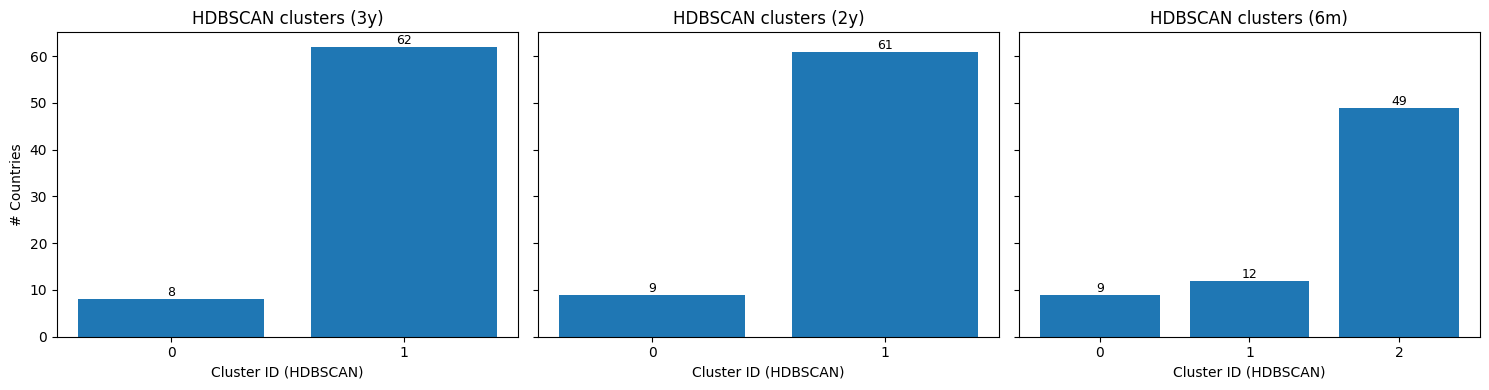

In [6]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

IN_DIR = "data/processed/clustering_umap_hdbscan"
pattern = os.path.join(IN_DIR, "countries_hdbscan_*.csv")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(f"No files matched: {pattern}")

series_by_window = []
for fp in files:
    df = pd.read_csv(fp)
    if "cluster_hdbscan" not in df.columns:
        raise ValueError(f"Missing 'cluster_hdbscan' column in: {fp}")

    window = os.path.splitext(os.path.basename(fp))[0].replace("countries_hdbscan_", "")
    counts = (
        df["cluster_hdbscan"]
        .astype(int)
        .value_counts()
        .sort_index()
    )
    series_by_window.append((window, counts))

preferred_order = ["3y", "2y", "6m"]
order_map = {w: i for i, w in enumerate(preferred_order)}
series_by_window.sort(key=lambda t: (order_map.get(t[0], 999), t[0]))

n = len(series_by_window)
fig_w = max(6, 5 * n)
fig, axes = plt.subplots(1, n, figsize=(fig_w, 4), sharey=True)
if n == 1:
    axes = [axes]

for ax, (window, counts) in zip(axes, series_by_window):
    x = counts.index.astype(int)
    y = counts.values
    ax.bar(x, y)
    ax.set_title(f"HDBSCAN clusters ({window})")
    ax.set_xlabel("Cluster ID (HDBSCAN)")
    ax.set_xticks(x)
    for xi, yi in zip(x, y):
        ax.text(xi, yi, str(int(yi)), ha="center", va="bottom", fontsize=9)

axes[0].set_ylabel("# Countries")
plt.tight_layout()
plt.show()